# Verify the weight of V+ FFNN(can not show the power of quantum)

## Prepare environment and  define parameters 

In [1]:
is_colab = False
import sys
if is_colab:
    try:
        import torch  
        print('Module torch was installed')
    except ImportError:    
        print("Installinng torch 1.8.1")
        !pip install -q torch==1.8.1
    try:
        import torchvision  
        print('Module torchvision was installed')
    except ImportError:    
        print("Installinng torchvision 0.4.0")
        !pip install -q torchvision==0.4.0
    
    try:
        import qiskit  
        print('Module qiskit was installed')
    except ImportError:    
        print("Installinng qiskit 0.14.0")
        !pip install -q qiskit==0.14.0

    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1VYR5kM8oCGaMXPIq0K1UY7u53a77vmHA' -O codes.tar.gz
    !tar zxvf /content/codes.tar.gz

    sys.path.append('/content/libs/')

import torch
import torchvision

import qiskit
from qiskit import  QuantumCircuit, ClassicalRegister
import numpy as np
import functools

In [2]:
sys.path.append('../')
from src.qfnn.qf_fb.q_output import fire_ibmq,analyze,add_measure
from src.qfnn.qf_circ.u_lyr_circ import U_LYR_Circ
from src.qfnn.qf_circ.v_lyr_circ import V_LYR_Circ
from src.qfnn.qf_net.utils import binarize
from src.qfnn.qf_fb.c_input import load_data,to_quantum_matrix

print = functools.partial(print, flush=True)



################ Zhirui on 12-30-2020 ################
# Parameters of settings
######################################################
interest_num = [3,6]
ori_img_size = 28
img_size = 4
num_workers = 0 # number of subprocesses to use for data loading
batch_size = 1# how many samples per batch to load
inference_batch_size = 1
isppd = False #is prepared data

################ Zhirui on 12-30-2020 ################
# path
######################################################
if is_colab:
    data_path = '/content/data' #mnist  path
    resume_path = '/content/libs/best_model/u_v.tar' #model path
else:
    data_path = '/home/hzr/Software/quantum/qc_mnist/pytorch/data' #mnist  path
    resume_path = '/home/hzr/Software/quantum/qc_mnist/model/exe_mnist.py_2021_08_09-00_00_30/model_best.tar' #model path

## Load data

In [3]:
################ Zhirui on 12-30-2020 ################
# load data.
######################################################

train_loader, test_loader = load_data(interest_num,data_path,isppd,img_size,batch_size,inference_batch_size,False)
for batch_idx, (data, target) in enumerate(test_loader):
    torch.set_printoptions(threshold=sys.maxsize)
    print("Batch Id: {}, Target: {}".format(batch_idx,target))
    quantum_matrix = to_quantum_matrix(data)
    break

Batch Id: 0, Target: tensor([0])


## u-layer Inference

In [4]:


# Model initialization

checkpoint = torch.load(resume_path, map_location='cpu')

weight = checkpoint['state_dict']['fc0.weight']
theta = checkpoint['state_dict']['fc2.theta']
# print(checkpoint['state_dict'])




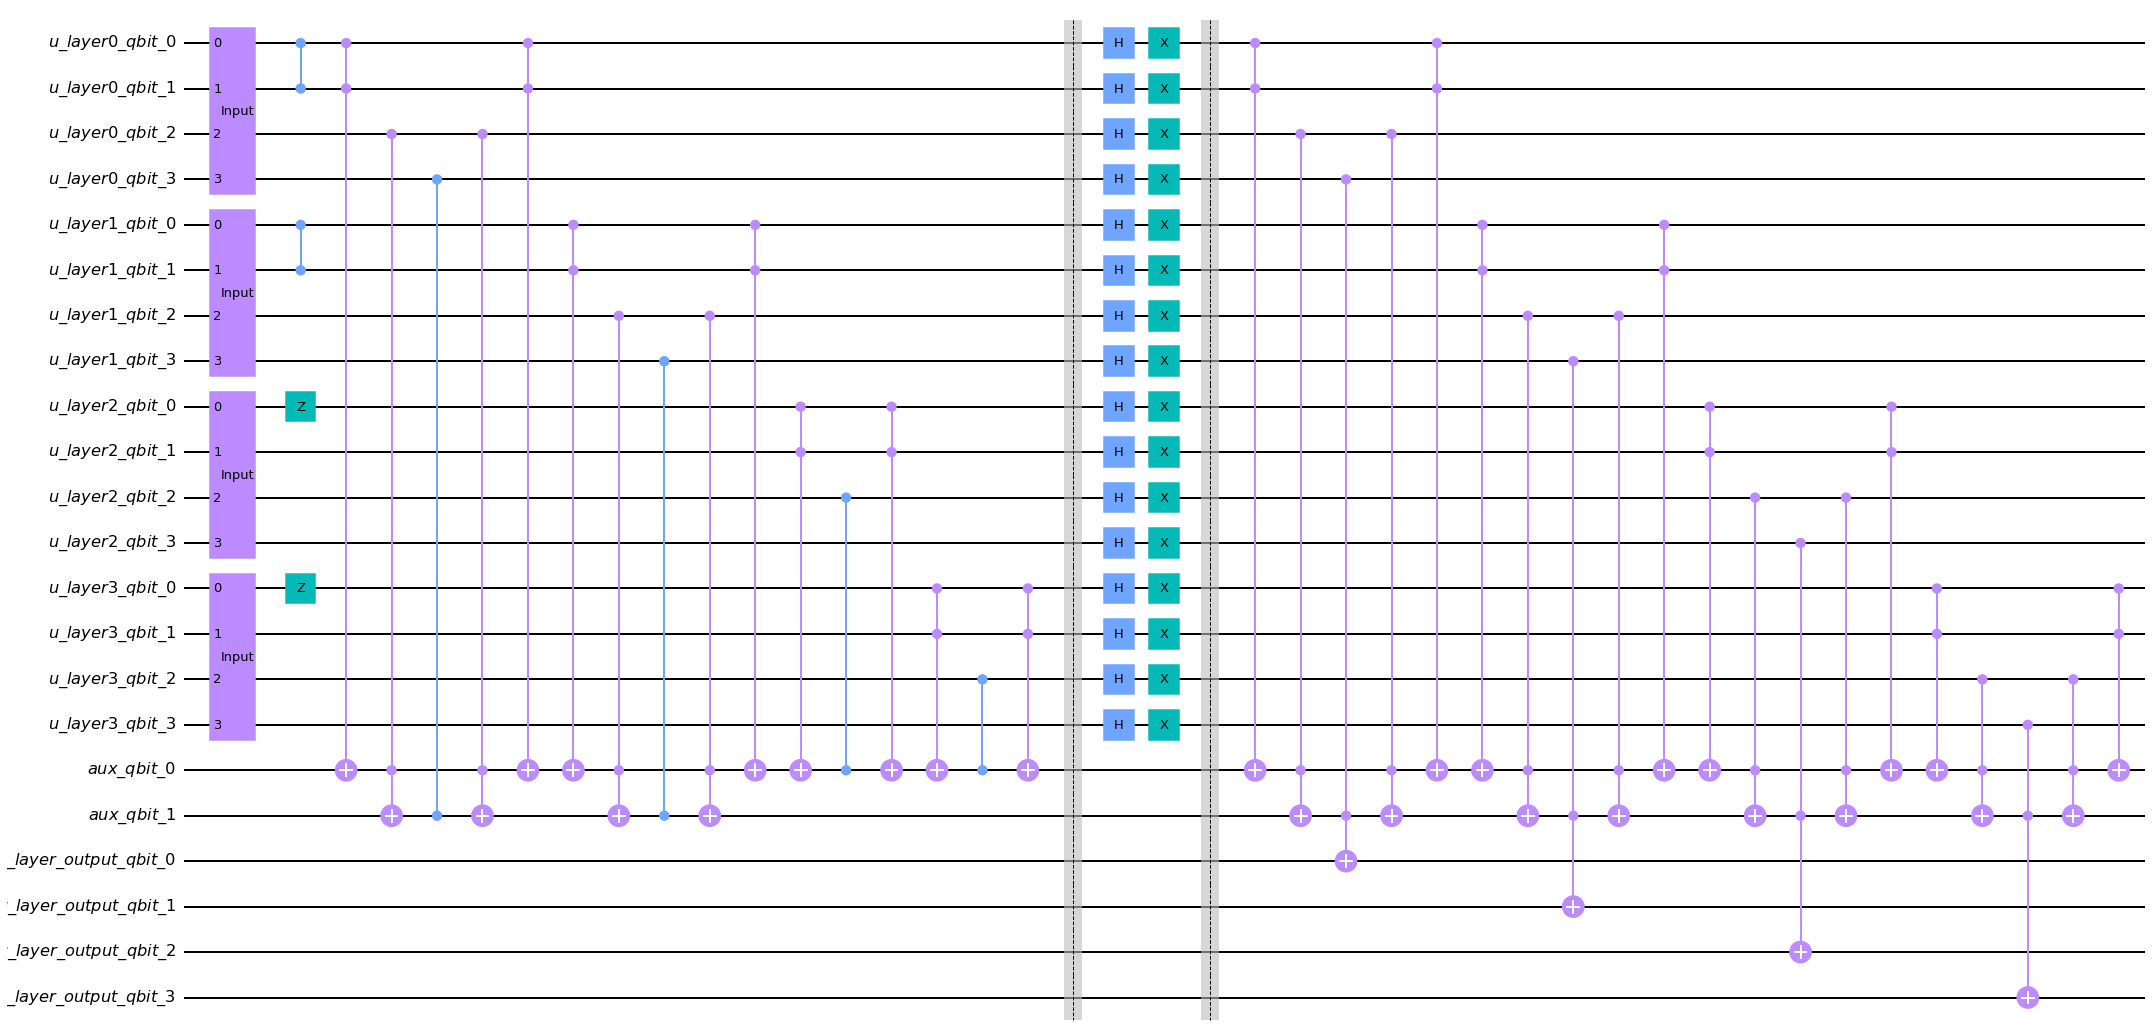

In [5]:
################ Weiwen on 12-30-2020 ################
# Generate the circuit of u-layer
######################################################

#define your input and output number
u_layer = U_LYR_Circ(4,4) 
#init circuit
circuit = QuantumCircuit()
#add input qubit to your circuit
inps = u_layer.add_input_qubits(circuit)

#add auxiliary qubit to your circuit
aux =u_layer.add_aux(circuit)

#add output qubit to your circuit
u_layer_out_qubits = u_layer.add_out_qubits(circuit)

#add ulayer to your circuit
u_layer.forward(circuit,binarize(weight),inps,u_layer_out_qubits,quantum_matrix,aux)

#show your circuit
if is_colab:
    layout = 'text'
    fold = 300
else:
    layout = 'mpl'
    fold = 50

circuit.draw(layout,fold=fold)



In [6]:
################ hzr on 12-30-2020 ################
# u-layer simulation
######################################################


circuit.barrier()
add_measure(circuit,u_layer_out_qubits,'reg')
qc_shots=8192
u_layer_counts = fire_ibmq(circuit,qc_shots,True)
(u_layer_counts,u_layer_bits) = analyze(u_layer_counts)


## v-layer inference

Result of u+v: [0.849853515625, 0.83984375]
Prediction class: 0
Target class: 0
Correct prediction


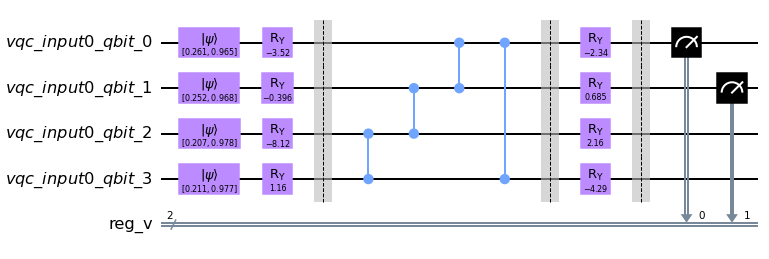

In [7]:
#init new circuit
circuit2 = QuantumCircuit()
vqc = V_LYR_Circ(4,1)
v_inputs = vqc.add_input_qubits(circuit2)

#init state by u-layer-measurement
for b in range(u_layer_bits):
    prob =float(u_layer_counts[b])/qc_shots
    initial_state = [prob,1-prob]
    initial_state = torch.tensor(initial_state,dtype=torch.cdouble)
    initial_state = torch.sqrt(initial_state)
    circuit2.initialize(np.array(initial_state) , b)

#add vqc to the circuit
vqc.forward(circuit2,v_inputs,'v10',np.array(theta))   

#add measurement to the circuit
circuit2.barrier()
add_measure(circuit2,v_inputs[0][0:2],'reg_v')


opt_counts = fire_ibmq(circuit2,qc_shots,True)

(opt_mycount,bits) = analyze(opt_counts)
opt_class_prob=[]
for b in range(2):
    opt_class_prob.append(float(opt_mycount[b])/qc_shots)
print("Result of u+v:",opt_class_prob)
print("Prediction class: {}".format(opt_class_prob.index(max(opt_class_prob))))
print("Target class: {}".format(target[0]))
if opt_class_prob.index(max(opt_class_prob))==target[0]:
    print("Correct prediction")
else:
    print("Incorrect prediction")
print("="*30)
circuit2.draw('mpl')